In [7]:
# =============================================================
# VISUALIZACIÓN DE LISTA ENLAZADA DE PEDIDOS
# =============================================================

import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import mysql.connector
from lst import ListaEnlazadaPedidos

load_dotenv()

True

In [12]:
# Crear lista enlazada y conexión a BD
lista_pedidos = ListaEnlazadaPedidos()

mydb = mysql.connector.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database=os.getenv("DB_NAME")
)
cursor = mydb.cursor(dictionary=True)

# Obtener pedidos con sus productos
cursor.execute("SELECT * FROM pedidos")
pedidos = cursor.fetchall()

for ped in pedidos:
    # Obtener productos de cada pedido
    cursor.execute("""
        SELECT pp.producto_id, p.nombre, p.precio, pp.cantidad
        FROM pedido_productos pp
        JOIN productos p ON p.producto_id = pp.producto_id
        WHERE pp.pedido_id = %s
    """, (ped["pedido_id"],))
    productos = cursor.fetchall()
    
    # Agregar pedido a la lista enlazada
    lista_pedidos.agregar_pedido(
        ped["pedido_id"],
        ped["cliente"],
        ped["fecha_pedido"].isoformat() if hasattr(ped["fecha_pedido"], 'isoformat') else str(ped["fecha_pedido"]),
        [{"producto_id": p["producto_id"], "nombre": p["nombre"], 
          "precio": float(p["precio"]), "cantidad": p["cantidad"]} for p in productos]
    )

cursor.close()
mydb.close()

# Mostrar pedidos cargados
print(f"Se cargaron {len(lista_pedidos.listar_pedidos())} pedidos:\n")
for p in lista_pedidos.listar_pedidos():
    print(f"  Pedido #{p['pedido_id']} - Cliente: {p['cliente']} - Productos: {len(p['productos'])}")

Se cargaron 2 pedidos:

  Pedido #1 - Cliente: Maria Jose Santos - Productos: 2
  Pedido #2 - Cliente: Elsy Edelmira Chevez - Productos: 2


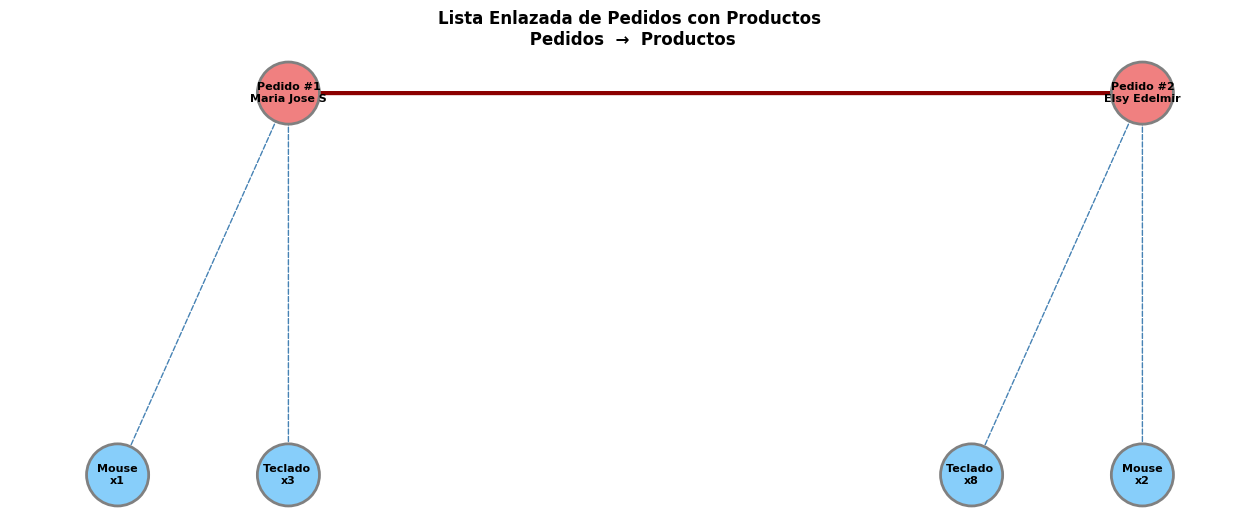

In [14]:
# =============================================================
# VISUALIZACIÓN DETALLADA: PEDIDOS CON SUS PRODUCTOS
# =============================================================

G2 = nx.DiGraph()
etiquetas2 = {}
colores2 = []

actual = lista_pedidos.cabeza
pedido_num = 0

while actual:
    # Nodo del pedido (rojo)
    pedido_node = f"Ped_{actual.pedido_id}"
    G2.add_node(pedido_node, tipo="pedido")
    etiquetas2[pedido_node] = f"Pedido #{actual.pedido_id}\n{actual.cliente[:12]}"
    colores2.append("lightcoral")
    
    # Conectar con siguiente pedido
    if actual.siguiente:
        next_pedido = f"Ped_{actual.siguiente.pedido_id}"
        G2.add_edge(pedido_node, next_pedido, tipo="enlace")
    
    # Agregar productos como nodos hijos (azul)
    if actual.productos:
        for i, prod in enumerate(actual.productos):
            prod_node = f"Prod_{actual.pedido_id}_{i}"
            G2.add_node(prod_node, tipo="producto")
            nombre_corto = prod["nombre"][:8] if len(prod["nombre"]) > 8 else prod["nombre"]
            etiquetas2[prod_node] = f"{nombre_corto}\nx{prod['cantidad']}"
            colores2.append("lightblue")
            G2.add_edge(pedido_node, prod_node, tipo="producto")
    
    actual = actual.siguiente
    pedido_num += 1

# Posicionar: pedidos en línea horizontal, productos debajo
pos2 = {}
pedido_x = 0
for node in G2.nodes():
    if node.startswith("Ped_"):
        pos2[node] = (pedido_x * 4, 1)
        pedido_x += 1

# Posicionar productos debajo de cada pedido
for node in G2.nodes():
    if node.startswith("Prod_"):
        parts = node.split("_")
        pedido_id = parts[1]
        prod_idx = int(parts[2])
        parent_pos = pos2[f"Ped_{pedido_id}"]
        pos2[node] = (parent_pos[0] - 0.8 + (prod_idx * 0.8), -0.5)

plt.figure(figsize=(16, 6))

# Separar colores por tipo
node_colors = ["lightcoral" if n.startswith("Ped_") else "lightskyblue" for n in G2.nodes()]

nx.draw_networkx_nodes(G2, pos2, node_size=2000, node_color=node_colors, 
                       edgecolors='gray', linewidths=2)

# Aristas entre pedidos 
edges_pedidos = [(u, v) for u, v in G2.edges() if v.startswith("Ped_")]
nx.draw_networkx_edges(G2, pos2, edgelist=edges_pedidos, arrows=True, 
                       arrowsize=20, edge_color='darkred', width=3)

# Aristas a productos
edges_productos = [(u, v) for u, v in G2.edges() if v.startswith("Prod_")]
nx.draw_networkx_edges(G2, pos2, edgelist=edges_productos, arrows=True, 
                       arrowsize=10, edge_color='steelblue', width=1, style='dashed')

nx.draw_networkx_labels(G2, pos2, labels=etiquetas2, font_size=8, font_weight='bold')

plt.title("Lista Enlazada de Pedidos con Productos\n Pedidos  →  Productos", 
          fontsize=12, fontweight='bold')
plt.axis('off')
plt.show()